In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
from einops import rearrange, reduce, repeat

In [6]:
dataset_name = 'ravdess'
experiment_prefix = "scb12"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 768
num_tokens_per_second = 64
num_classes = 4
commitment_cost = 0.1
num_mamba_block=1

In [7]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB12 as SCB
from omegaconf import OmegaConf as ocf

n_epoch = 4

loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=1, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8, gradient_clip_val=1.)

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
2


In [16]:
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=cls_dim,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    num_mamba_block=num_mamba_block,
    num_tokens_per_second=num_tokens_per_second,
    max_num_tokens=max_num_tokens
)

In [9]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [10]:
model.codebook_pretrained_path

'../scb11_models/ravdess/epoch=220.codebook.pt'

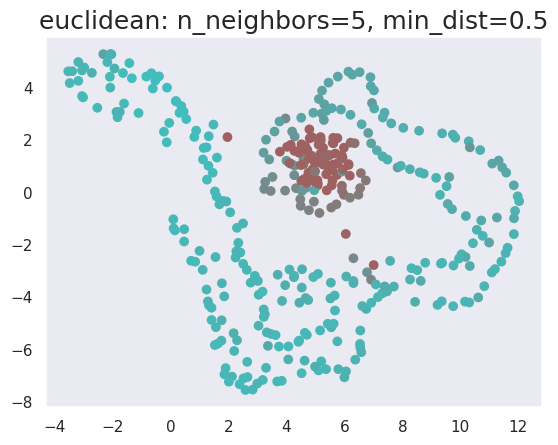

In [11]:
emb = torch.load(model.codebook_pretrained_path)
emb_color, zcs = get_embedding_color_v2(emb)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

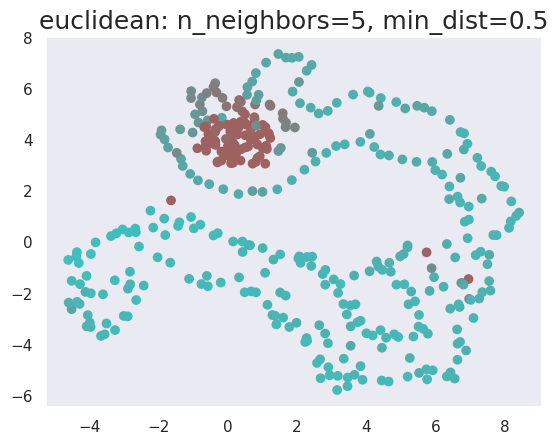

In [12]:
emb = model.filter_codebook.data.cpu()
emb_color, zcs = get_embedding_color_v2(emb)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

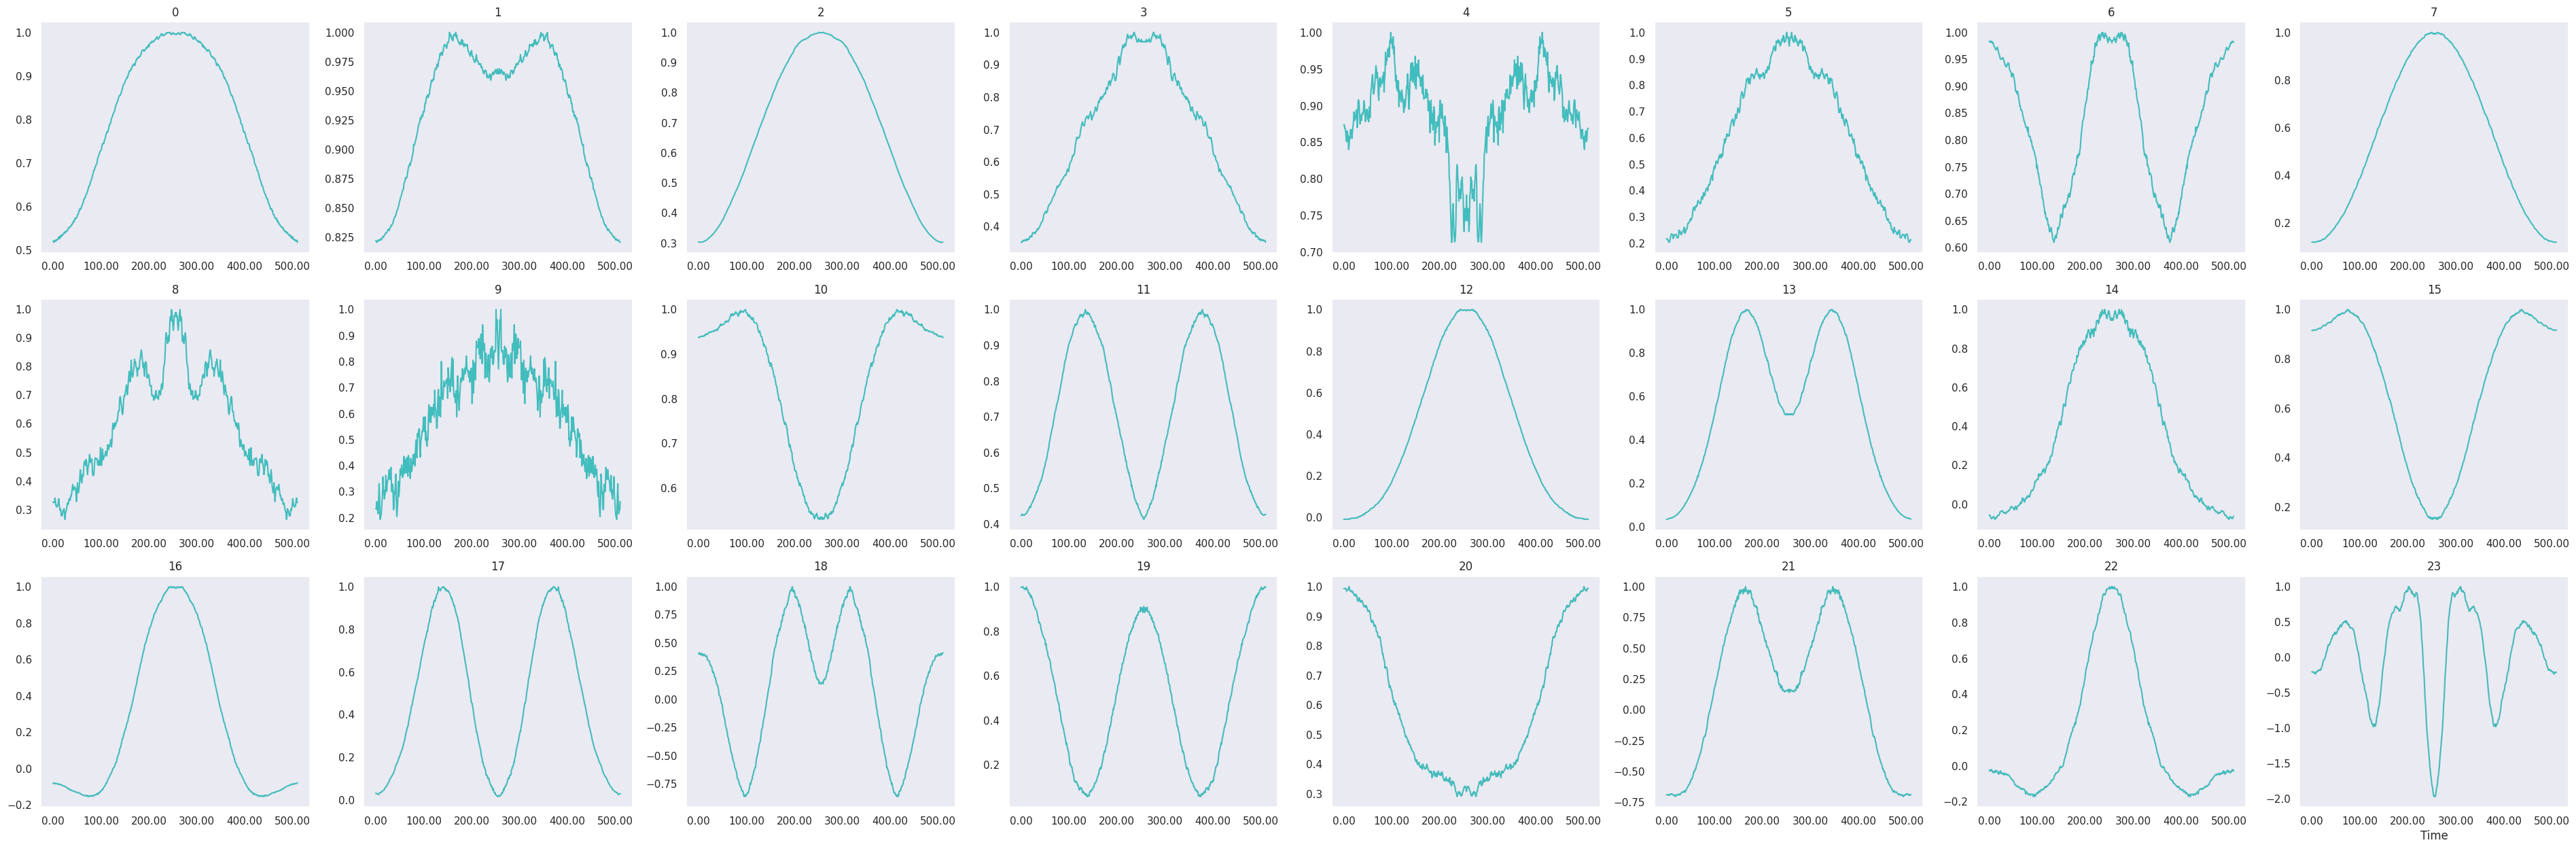

In [13]:
selected_emb_topk = torch.topk(zcs, 24)
selected_idx = selected_emb_topk.indices[-24:]
visualize_speech_codebook(
    emb[selected_idx].numpy(), 
    n=24, colors=emb_color[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

In [17]:
trainer.setup(model=model, lr=learning_rate)

In [18]:
trainer.fit(n_epoch=200, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|                              | 0.3349875930521097/200 [00:52<36:40:11, 661.16s/it]

Epoch: 1	Loss: 6.033 [perplexity=109.048, loss_vq=0.038, loss_recon=4.739, loss_cls=1.293]	Val_acc: 9/27 (33.33%)

Saved new best val model: ../scb12_models/ravdess/model.epoch=1.step=118.loss=6.033.val_acc=0.333.pt


  1%|▏                              | 1.0000000000000067/200 [02:19<6:21:55, 115.15s/it]

Correct: 39/135 (0.2889)
Saved new best test model: ../scb12_models/ravdess/model.epoch=1.step=234.test_acc=0.2889.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1804, device='cuda:0'),
 'f1s_weighted': tensor(0.2085, device='cuda:0'),
 'rocauc': tensor(0.5167, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.1650, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.3590, 0.6410], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.2979, 0.4237], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2545, 0.3165], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.3590, 0.6410], device='cuda:0'),
 'rocauc_detail': tensor([0.5445, 0.5363, 0.4631, 0.5227], device='cuda:0')}
tensor([[ 0,  0, 20, 18],
        [ 0,  0,  8, 11],
        [ 0,  0, 14, 25],
        [ 1,  0, 13, 25]], device='cuda:0')


  1%|▏                              | 1.334987593052104/200 [03:11<36:16:23, 657.31s/it]

Epoch: 2	Loss: 4.949 [perplexity=110.787, loss_vq=0.041, loss_recon=3.812, loss_cls=1.137]	Val_acc: 9/27 (33.33%)



  1%|▎                             | 1.9999999999999714/200 [04:51<36:46:40, 668.69s/it]

Epoch: 3	Loss: 4.303 [perplexity=63.751, loss_vq=0.042, loss_recon=3.230, loss_cls=1.073]	Val_acc: 3/27 (11.11%)



  1%|▍                              | 2.665012406947898/200 [06:32<36:23:36, 663.93s/it]

Epoch: 4	Loss: 4.241 [perplexity=54.176, loss_vq=0.042, loss_recon=2.946, loss_cls=1.295]	Val_acc: 5/27 (18.52%)



  2%|▌                              | 3.330024813895825/200 [08:12<36:31:33, 668.60s/it]

Epoch: 5	Loss: 5.374 [perplexity=132.710, loss_vq=0.043, loss_recon=3.459, loss_cls=1.915]	Val_acc: 9/27 (33.33%)



  2%|▌                             | 3.9950372208437517/200 [09:53<35:49:44, 658.07s/it]

Epoch: 6	Loss: 4.966 [perplexity=108.734, loss_vq=0.042, loss_recon=3.418, loss_cls=1.548]	Val_acc: 5/27 (18.52%)



  2%|▋                              | 4.660049627791678/200 [11:33<35:55:34, 662.10s/it]

Epoch: 7	Loss: 4.922 [perplexity=111.142, loss_vq=0.040, loss_recon=3.435, loss_cls=1.487]	Val_acc: 6/27 (22.22%)



  3%|▊                              | 5.325062034739605/200 [13:13<35:48:51, 662.29s/it]

Epoch: 8	Loss: 4.909 [perplexity=87.517, loss_vq=0.040, loss_recon=3.275, loss_cls=1.634]	Val_acc: 7/27 (25.93%)



  3%|▉                              | 5.990074441687532/200 [14:53<35:42:37, 662.63s/it]

Epoch: 9	Loss: 4.551 [perplexity=89.457, loss_vq=0.057, loss_recon=3.375, loss_cls=1.176]	Val_acc: 12/27 (44.44%)

Saved new best val model: ../scb12_models/ravdess/model.epoch=9.step=1990.loss=4.551.val_acc=0.444.pt


  3%|█                              | 6.655086848635459/200 [16:34<35:25:53, 659.72s/it]

Epoch: 10	Loss: 4.686 [perplexity=124.571, loss_vq=0.049, loss_recon=3.617, loss_cls=1.069]	Val_acc: 5/27 (18.52%)



  4%|█                             | 7.3200992555833855/200 [18:14<35:23:56, 661.39s/it]

Epoch: 11	Loss: 4.556 [perplexity=98.958, loss_vq=0.039, loss_recon=3.271, loss_cls=1.285]	Val_acc: 9/27 (33.33%)



  4%|█▎                              | 7.985111662531312/200 [19:40<6:08:12, 115.06s/it]

Correct: 35/135 (0.2593)
{'acc_unweighted': tensor(0.2252, device='cuda:0'),
 'acc_weighted': tensor(0.2593, device='cuda:0'),
 'f1s_unweighted': tensor(0.1436, device='cuda:0'),
 'f1s_weighted': tensor(0.1650, device='cuda:0'),
 'rocauc': tensor(0.3487, device='cuda:0'),
 'uar': tensor(0.2252, device='cuda:0'),
 'wap': tensor(0.1264, device='cuda:0')}
{'acc_detail': tensor([0.1316, 0.0000, 0.0000, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.1299, 0.0000, 0.0000, 0.4444], device='cuda:0'),
 'precision_detail': tensor([0.1282, 0.0000, 0.0000, 0.3125], device='cuda:0'),
 'recall_detail': tensor([0.1316, 0.0000, 0.0000, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.2941, 0.2536, 0.3336, 0.5136], device='cuda:0')}
tensor([[ 5,  0,  0, 33],
        [11,  0,  0,  8],
        [14,  0,  0, 25],
        [ 9,  0,  0, 30]], device='cuda:0')


  4%|█▎                             | 8.320099255583324/200 [20:33<35:02:26, 658.11s/it]

Epoch: 12	Loss: 4.102 [perplexity=47.618, loss_vq=0.039, loss_recon=2.762, loss_cls=1.340]	Val_acc: 9/27 (33.33%)



  4%|█▍                             | 8.985111662531013/200 [22:13<35:27:18, 668.21s/it]

Epoch: 13	Loss: 4.591 [perplexity=74.764, loss_vq=0.043, loss_recon=3.237, loss_cls=1.354]	Val_acc: 12/27 (44.44%)



  5%|█▍                             | 9.650124069478702/200 [23:55<36:06:49, 683.00s/it]

Epoch: 14	Loss: 4.812 [perplexity=138.043, loss_vq=0.043, loss_recon=3.464, loss_cls=1.348]	Val_acc: 9/27 (33.33%)



  5%|█▌                             | 10.31513647642639/200 [25:37<35:09:49, 667.37s/it]

Epoch: 15	Loss: 4.679 [perplexity=116.818, loss_vq=0.036, loss_recon=3.363, loss_cls=1.316]	Val_acc: 7/27 (25.93%)



  5%|█▋                             | 10.98014888337408/200 [27:19<35:43:19, 680.35s/it]

Epoch: 16	Loss: 4.513 [perplexity=108.510, loss_vq=0.031, loss_recon=3.277, loss_cls=1.236]	Val_acc: 5/27 (18.52%)



  6%|█▋                            | 11.645161290321768/200 [29:01<35:09:25, 671.95s/it]

Epoch: 17	Loss: 4.195 [perplexity=68.287, loss_vq=0.040, loss_recon=2.990, loss_cls=1.205]	Val_acc: 7/27 (25.93%)



  6%|█▊                            | 12.310173697269457/200 [30:42<34:36:23, 663.77s/it]

Epoch: 18	Loss: 4.484 [perplexity=109.319, loss_vq=0.041, loss_recon=3.303, loss_cls=1.181]	Val_acc: 7/27 (25.93%)



  6%|█▉                            | 12.975186104217146/200 [32:23<35:07:57, 676.26s/it]

Epoch: 19	Loss: 4.320 [perplexity=78.879, loss_vq=0.042, loss_recon=3.059, loss_cls=1.262]	Val_acc: 7/27 (25.93%)



  7%|██                            | 13.640198511164835/200 [34:04<34:43:52, 670.92s/it]

Epoch: 20	Loss: 4.861 [perplexity=131.625, loss_vq=0.037, loss_recon=3.314, loss_cls=1.547]	Val_acc: 5/27 (18.52%)



  7%|██▏                           | 14.305210918112524/200 [35:45<34:36:52, 671.06s/it]

Epoch: 21	Loss: 4.489 [perplexity=107.901, loss_vq=0.034, loss_recon=3.265, loss_cls=1.224]	Val_acc: 7/27 (25.93%)



  7%|██▎                            | 14.970223325060212/200 [37:12<6:02:28, 117.54s/it]

Correct: 37/135 (0.2741)
{'acc_unweighted': tensor(0.2384, device='cuda:0'),
 'acc_weighted': tensor(0.2741, device='cuda:0'),
 'f1s_unweighted': tensor(0.1557, device='cuda:0'),
 'f1s_weighted': tensor(0.1784, device='cuda:0'),
 'rocauc': tensor(0.5146, device='cuda:0'),
 'uar': tensor(0.2384, device='cuda:0'),
 'wap': tensor(0.1447, device='cuda:0')}
{'acc_detail': tensor([0.1842, 0.0000, 0.0000, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.1972, 0.0000, 0.0000, 0.4255], device='cuda:0'),
 'precision_detail': tensor([0.2121, 0.0000, 0.0000, 0.2941], device='cuda:0'),
 'recall_detail': tensor([0.1842, 0.0000, 0.0000, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.6289, 0.3857, 0.5628, 0.4810], device='cuda:0')}
tensor([[ 7,  0,  0, 31],
        [ 6,  0,  0, 13],
        [11,  0,  0, 28],
        [ 9,  0,  0, 30]], device='cuda:0')


  8%|██▎                            | 15.30521091811222/200 [38:06<34:00:17, 662.81s/it]

Epoch: 22	Loss: 4.700 [perplexity=155.204, loss_vq=0.042, loss_recon=3.572, loss_cls=1.129]	Val_acc: 7/27 (25.93%)



  8%|██▍                           | 15.970223325059909/200 [39:47<34:07:10, 667.45s/it]

Epoch: 23	Loss: 4.281 [perplexity=62.801, loss_vq=0.038, loss_recon=2.925, loss_cls=1.356]	Val_acc: 5/27 (18.52%)



  8%|██▍                           | 16.635235732008052/200 [41:28<34:20:18, 674.16s/it]

Epoch: 24	Loss: 5.091 [perplexity=125.459, loss_vq=0.050, loss_recon=3.520, loss_cls=1.570]	Val_acc: 6/27 (22.22%)



  9%|██▌                           | 17.300248138956217/200 [43:09<34:03:05, 670.97s/it]

Epoch: 25	Loss: 4.169 [perplexity=75.331, loss_vq=0.031, loss_recon=2.929, loss_cls=1.240]	Val_acc: 6/27 (22.22%)



  9%|██▋                           | 17.965260545904382/200 [44:51<33:52:41, 669.99s/it]

Epoch: 26	Loss: 4.563 [perplexity=66.904, loss_vq=0.038, loss_recon=2.919, loss_cls=1.644]	Val_acc: 4/27 (14.81%)



  9%|██▊                           | 18.630272952852547/200 [46:32<33:25:17, 663.38s/it]

Epoch: 27	Loss: 5.007 [perplexity=110.150, loss_vq=0.043, loss_recon=3.254, loss_cls=1.754]	Val_acc: 6/27 (22.22%)



 10%|██▉                            | 19.29528535980071/200 [48:15<34:25:09, 685.70s/it]

Epoch: 28	Loss: 4.573 [perplexity=115.176, loss_vq=0.039, loss_recon=3.421, loss_cls=1.151]	Val_acc: 4/27 (14.81%)



 10%|██▉                           | 19.960297766748877/200 [49:56<33:20:18, 666.62s/it]

Epoch: 29	Loss: 4.792 [perplexity=105.052, loss_vq=0.033, loss_recon=3.318, loss_cls=1.474]	Val_acc: 6/27 (22.22%)



 10%|███▏                           | 20.62531017369704/200 [51:38<33:05:28, 664.13s/it]

Epoch: 30	Loss: 4.639 [perplexity=116.370, loss_vq=0.042, loss_recon=3.248, loss_cls=1.391]	Val_acc: 3/27 (11.11%)



 11%|███▏                          | 21.290322580645206/200 [53:19<33:16:43, 670.38s/it]

Epoch: 31	Loss: 4.316 [perplexity=70.438, loss_vq=0.044, loss_recon=3.080, loss_cls=1.236]	Val_acc: 6/27 (22.22%)



 11%|███▌                            | 21.95533498759337/200 [54:47<5:59:35, 121.18s/it]

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.4910, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.4216, 0.5404, 0.4874, 0.5147], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


 11%|███▌                            | 22.08436724565794/200 [55:07<7:20:45, 148.64s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x797fbfaf1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 11%|███▍                           | 22.086848635236105/200 [55:07<7:24:06, 149.77s/it]


RuntimeError: DataLoader worker (pid(s) 1886462, 1886470, 1886478, 1886486, 1886494, 1886502, 1886510, 1886518) exited unexpectedly

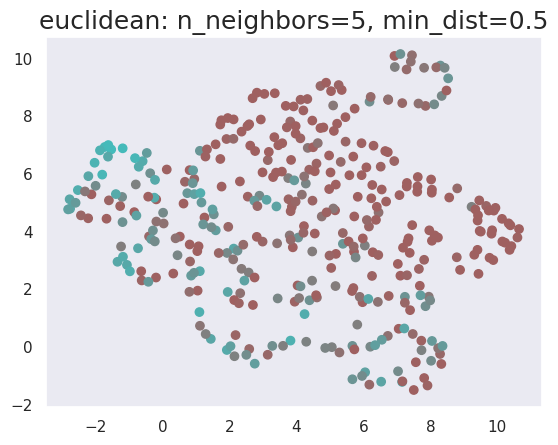

In [19]:
latent_emb_500 = trainer.model.latent_codebook.data.cpu()
latent_color_500, latent_zcs_500 = get_embedding_color_v2(latent_emb_500)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(latent_emb_500, colors=latent_color_500, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

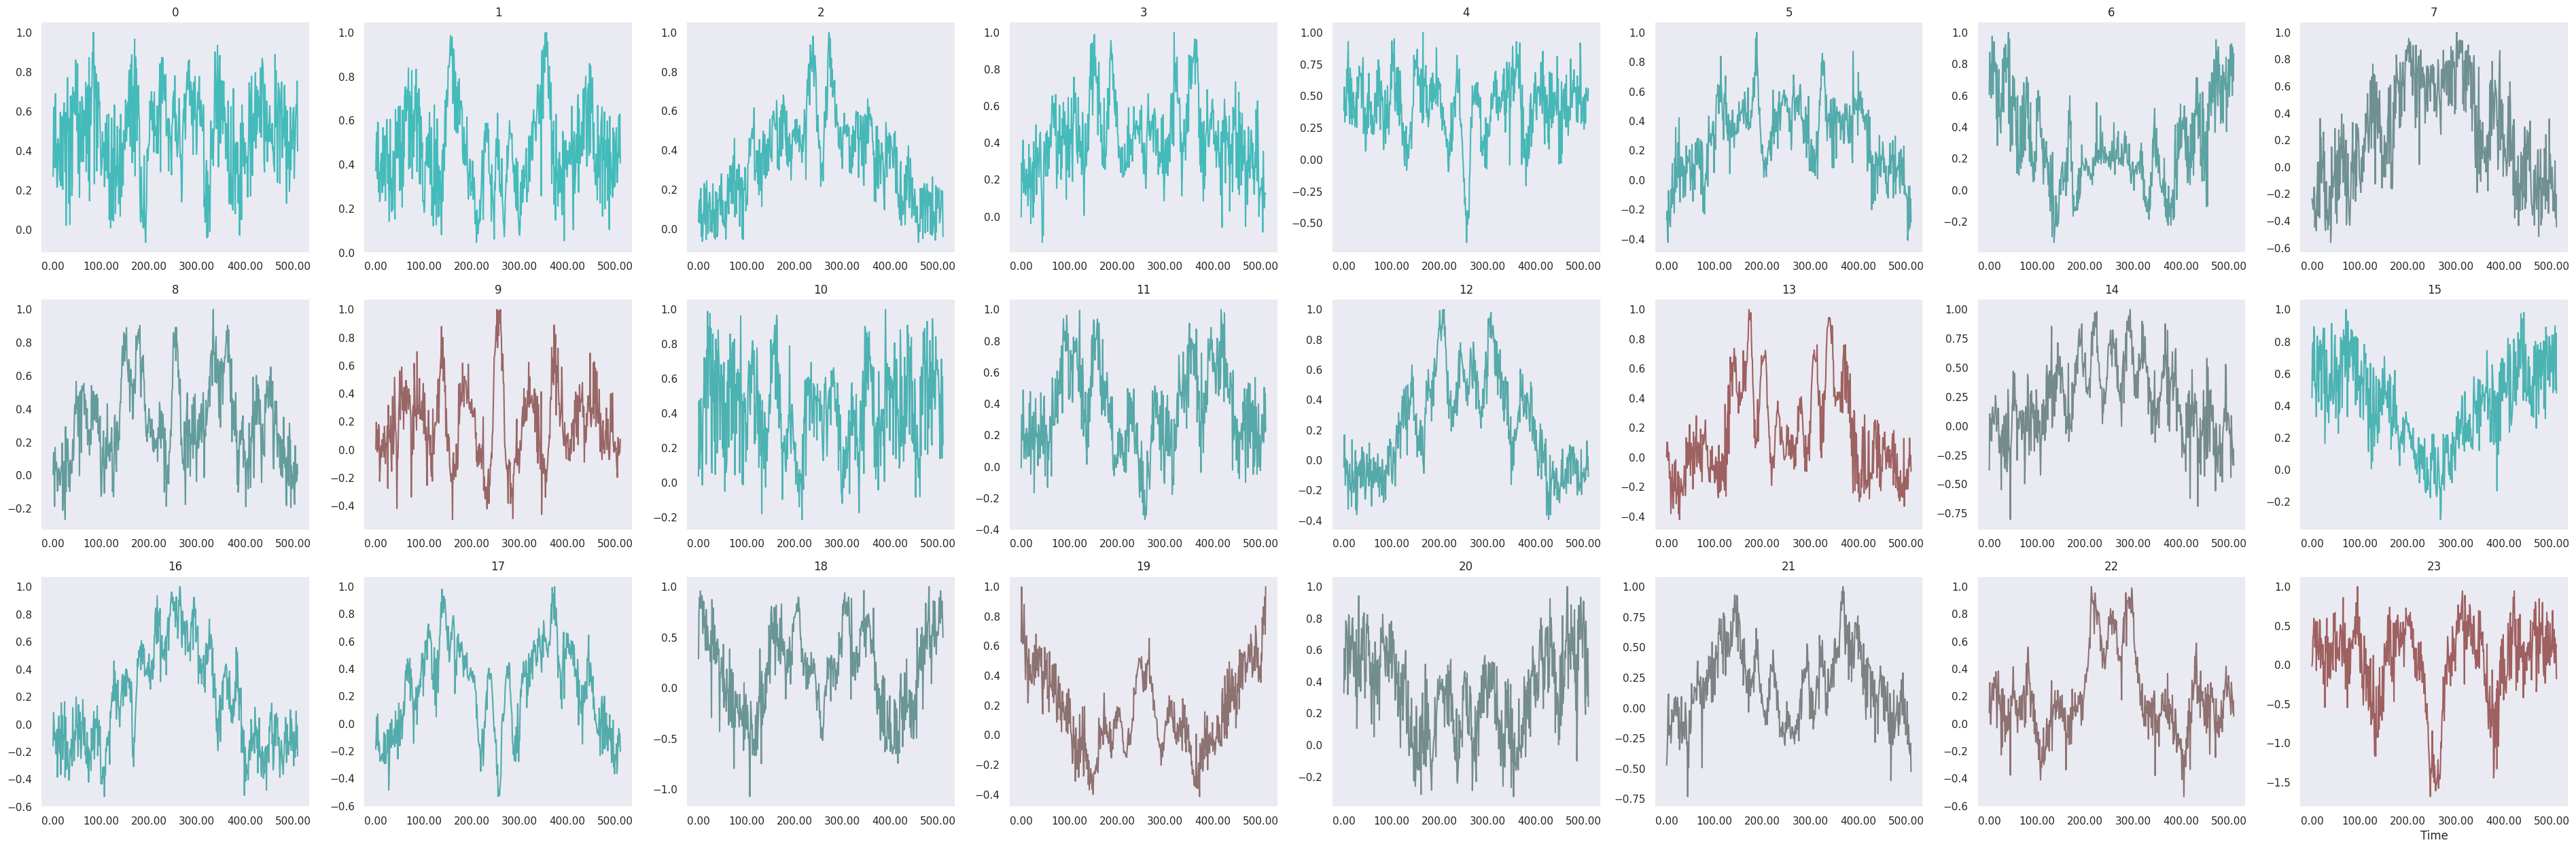

In [20]:
visualize_speech_codebook(
    latent_emb_500[selected_idx].numpy(), 
    n=24, colors=latent_color_500[selected_idx], 
    feature_mel=False, waveplot_librosa=False)